In [780]:
import numpy as np 
import matplotlib.pyplot as plt 
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from tqdm.notebook import tnrange, tqdm_notebook

In [781]:
freq = np.logspace(3, 7, 1000)  #[Hz]
omega = 2*np.pi*freq #[rad/s]   angular frequency in [rad/s] corresponding to [1kHz,1000kHz]

In [782]:
def X_L(omega, L):
    return 1j*omega*L 

def X_C(omega,C):
    return 1/(1j*omega*C)



### Parametri

$X_L = j\omega L$

In [783]:
class ComposeTF:
    Rp = 0 #Ohm
    Rs = 0#Ohm
    Lp = 1e-7 #Henry
    Ls = 127e-2 #Henry
    Cp = 1e-5 #Farad
    Cs = 1e-12 #Farad 
    k = 0.1 #Coupling efficiency (coefficient of the mutual inductance)
    
    def __init__(self, X = None):
        if X is not None:
            self.Rp = X[0]
            self.Rs = X[1]
            self.Lp = X[2]
            self.Ls = X[3]
            self.Cp = X[4]
            self.Cs = X[5]
            self.k = X[6]
    
    def get_tf(self):
        M = self.k*np.sqrt(self.Lp*self.Ls)
        Zp_star = X_C(omega, self.Cp) + self.Rp + X_L(omega, (self.Lp - M))
        Zs_star = self.Rs + X_L(omega, (self.Ls - M))
        return 1/((Zp_star + X_L(omega, M)) /X_L(omega, M) * (1+X_L(omega, self.Cs)*(Zs_star + X_L(omega, M))) - ((1j*omega)**2)*self.Cs*M)

def tf2db(T):
    return 20 * np.log10(np.abs(T))

In [784]:
def plotTF(opt):
    T = opt.get_tf()
    T_db = tf2db(T)
    plt.semilogx(freq, tf2db(T))

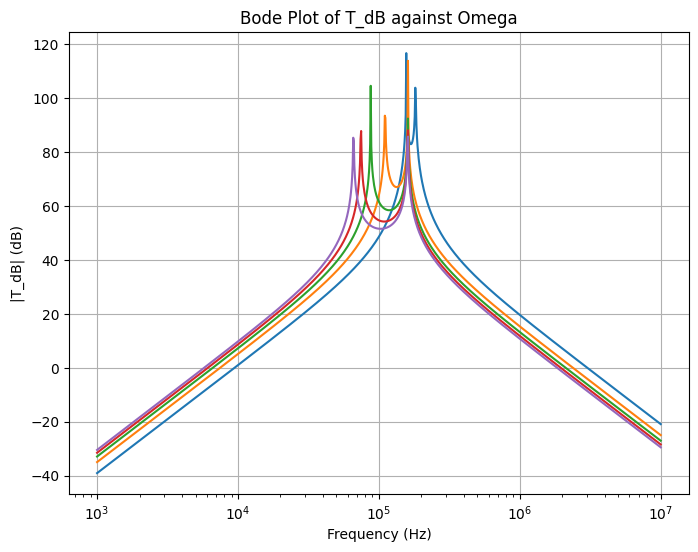

In [785]:
# Plot the data on a log-log scale
plt.figure(figsize=(8, 6))
Lp_set = np.linspace(80, 580, 5)*1e-2

opt = ComposeTF()

for Lp in Lp_set:
    opt.Ls = Lp
    plotTF(opt)

plt.title('Bode Plot of T_dB against Omega')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|T_dB| (dB)')
plt.grid(True)
plt.show()

In [798]:
def evaluate_model(X):
    gen = ComposeTF(X)
    T = gen.get_tf()
    T_db = tf2db(T)
    return np.max(T_db) # Return additional distance between peaks 


def evaluate_model_position(X):
    gen = ComposeTF(X)
    T = gen.get_tf()
    T_db = tf2db(T)
    return np.argmax(T_db) # Return additional distance between peaks     

In [787]:
names = ['Rp', 'Rs', 'Lp', 'Ls', 'Cp', 'Cs', 'k']

problem = {
    'num_vars': 7,
    'names': names,
    'bounds': [[0.001, 0.01],
               [100, 500],
               [1e-7, 2e-6],
               [1e-3, 50e-3],
               [0.5e-5,2e-5],
               [1e-13, 1e-12],
               [0.05, 0.5]]
}

param_values = saltelli.sample(problem, 2**17) 

n = param_values.shape[0]
Y = np.zeros([n])
for i in tnrange(n):
    X = param_values[i]
    Y[i] = evaluate_model(X) 
    
Si = sobol.analyze(problem, Y)

/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_25008/3072608376.py:15: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**17)


  0%|          | 0/2097152 [00:00<?, ?it/s]

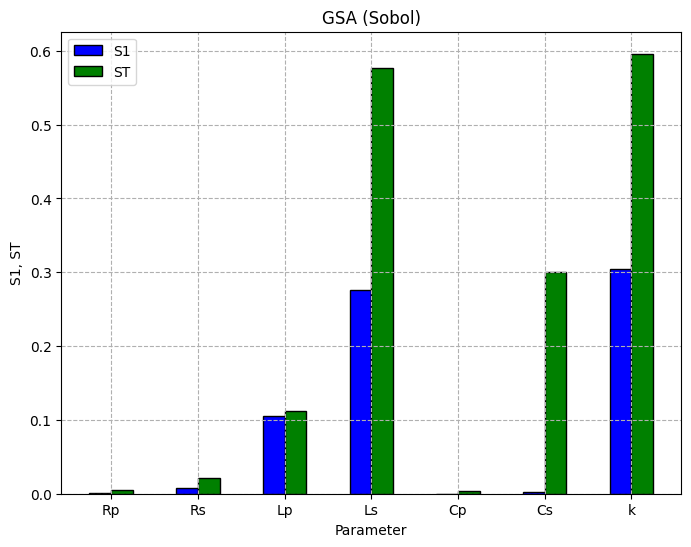

In [788]:
S1 = Si['S1']
ST = Si['ST']

plt.figure(figsize=(8, 6))
n=len(S1)
r = np.arange(n) 
width = 0.25
  
plt.bar(r, S1, color = 'b', 
        width = width, edgecolor = 'black', 
        label='S1') 
plt.bar(r + width, ST, color = 'g', 
        width = width, edgecolor = 'black', 
        label='ST') 
  
plt.xlabel("Parameter") 
plt.ylabel("S1, ST") 
plt.title("GSA (Sobol)") 
  
plt.grid(linestyle='--') 
plt.xticks(r + width/2, names) 
plt.legend() 
  
plt.show() 

/var/folders/b6/6j8727kd7j70w1zj_dxmknww0000gn/T/ipykernel_25008/1818456303.py:15: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**17)


  0%|          | 0/2097152 [00:00<?, ?it/s]

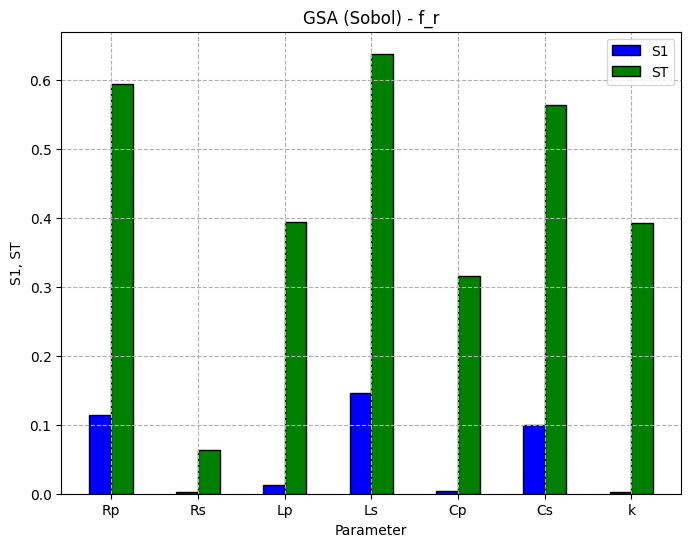

In [801]:
names = ['Rp', 'Rs', 'Lp', 'Ls', 'Cp', 'Cs', 'k']

problem = {
    'num_vars': 7,
    'names': names,
    'bounds': [[0.001, 0.01],
               [100, 500],
               [1e-7, 2e-6],
               [1e-3, 50e-3],
               [0.5e-5,2e-5],
               [1e-13, 1e-12],
               [0.05, 0.5]]
}

param_values = saltelli.sample(problem, 2**17) 

n = param_values.shape[0]
Y = np.zeros([n])
for i in tnrange(n):
    X = param_values[i]
    Y[i] = evaluate_model_position(X) 
    
Si = sobol.analyze(problem, Y)

S1 = Si['S1']
ST = Si['ST']

plt.figure(figsize=(8, 6))
n=len(S1)
r = np.arange(n) 
width = 0.25
  
plt.bar(r, S1, color = 'b', 
        width = width, edgecolor = 'black', 
        label='S1') 
plt.bar(r + width, ST, color = 'g', 
        width = width, edgecolor = 'black', 
        label='ST') 
  
plt.xlabel("Parameter") 
plt.ylabel("S1, ST") 
plt.title("GSA (Sobol) - f_r") 
  
plt.grid(linestyle='--') 
plt.xticks(r + width/2, names) 
plt.legend() 
  
plt.show() 